# Bayesian Linear Regression

> Bayesian Linear Regression module

In [ ]:
#| hide
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [ ]:
#| hide
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)
np.random.seed(42)
# Set matplotlib settings

plt.style.use('default')

In [ ]:
#| hide
date = pd.date_range(start="2018-12-25", end="2022-01-01", freq="W-Mon")[:156]
week_indx = np.arange(0, 156)
df = pd.DataFrame()
df["week_indx"] = week_indx
df["date"] = date

In [ ]:
#| hide
df["linear_trend"] = df["week_indx"]/155.0*3 - 1.5
df.head()

,week_indx,date,linear_trend
0,0,2018-12-31,-1.500000
1,1,2019-01-07,-1.480645
2,2,2019-01-14,-1.461290
3,3,2019-01-21,-1.441935
4,4,2019-01-28,-1.422581


In [ ]:
#| hide
rng = np.random.default_rng()

In [ ]:
#| hide
mus = [50, 100, 25, 175]
sigmas = np.array([[5, -.135, .35, .01],[-.135, 1, .6, .3],[.35, .6, .5, 0],[.01, .3, 0, 2]])
df[["OLV", "Social", "Display", "OTT"]]= np.abs(np.round(rng.multivariate_normal(mus, (sigmas*1000), size=156), 0))
df["Search"] = np.abs(np.round(df[["OLV", "Social", "Display", "OTT"]]@[1.5, .5, 2, .1] + np.random.normal(loc=20, scale=500, size=156)))

In [ ]:
media_vars = ["OLV", "Social", "Display", "OTT", "Search"]
media_transforms = {media: {"K": np.random.randint(int(df[media].min()), int(df[media].max()*1.1)), "n":np.random.uniform(.8, 3)} for media in media_vars}
media_vars_trans = [media+"_trans" for media in media_vars]

In [ ]:
def s_curve(x, K, n):
    return (x**n)/(x**n+K**n)

In [ ]:
df[media_vars_trans] = np.array([s_curve(df[media], **media_transforms[media]).values for media in media_vars]).T

In [ ]:
def seasonality(x):
    return np.sin(x*2*np.pi/52)-np.sin(x*6*np.pi/52)+.5*np.sin(x*8*np.pi/52)

In [ ]:
df["season"]=seasonality(df["week_indx"])

[<matplotlib.lines.Line2D>]

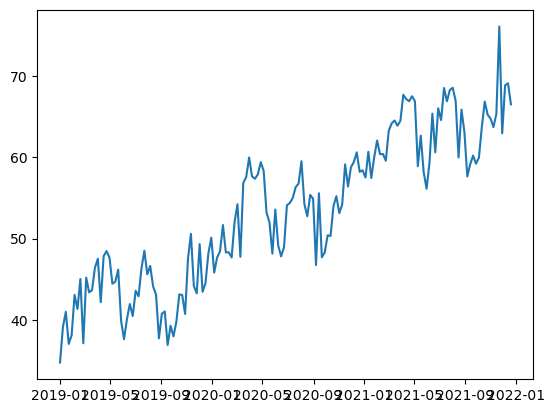

In [ ]:
#|output
model_vars = media_vars_trans+["linear_trend", "season"]
coeffs = pd.DataFrame()
coeffs[model_vars] = [[5, 2, 1.5, 1, .5, 10, 3]]
beta = 50
df["revenue"] = df[model_vars]@coeffs[model_vars].values[0] + beta + np.random.normal(loc=0, scale=2, size=156)
plt.plot(df['date'], df["revenue"])

In [ ]:
#| default_exp core
class BayesianLinearRegression():
    def __init__(self, n_inputs):
        self.n_inputs = n_inputs
        

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()